### Import

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, classification_report

### Enable GPU

In [2]:
gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        pass

Num GPUs Available:  1


### Load data

In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

### Dataset Analysis

In [4]:
# Print some information about the dataset
print(f"The shape of the training data is: {X_train.shape}")
print(f"The shape of the testing data is: {X_test.shape}")
print(f"The shape of the training labels is: {y_train.shape}")
print(f"The shape of the testing labels is: {y_test.shape}")

The shape of the training data is: (60000, 28, 28)
The shape of the testing data is: (10000, 28, 28)
The shape of the training labels is: (60000,)
The shape of the testing labels is: (10000,)


In [5]:
# Create a dataframe from the training data
train_df = pd.DataFrame.from_records(X_train.reshape(-1, 28*28))

# Add the labels to the dataframe
train_df['label'] = y_train

# Create a dataframe from the testing data
test_df = pd.DataFrame.from_records(X_test.reshape(-1, 28*28))

# Add the labels to the dataframe
test_df['label'] = y_test

In [6]:
# Display the first 5 rows of the training data
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


In [7]:
# Display the first 5 rows of the testing data
test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
Name: label, dtype: int64

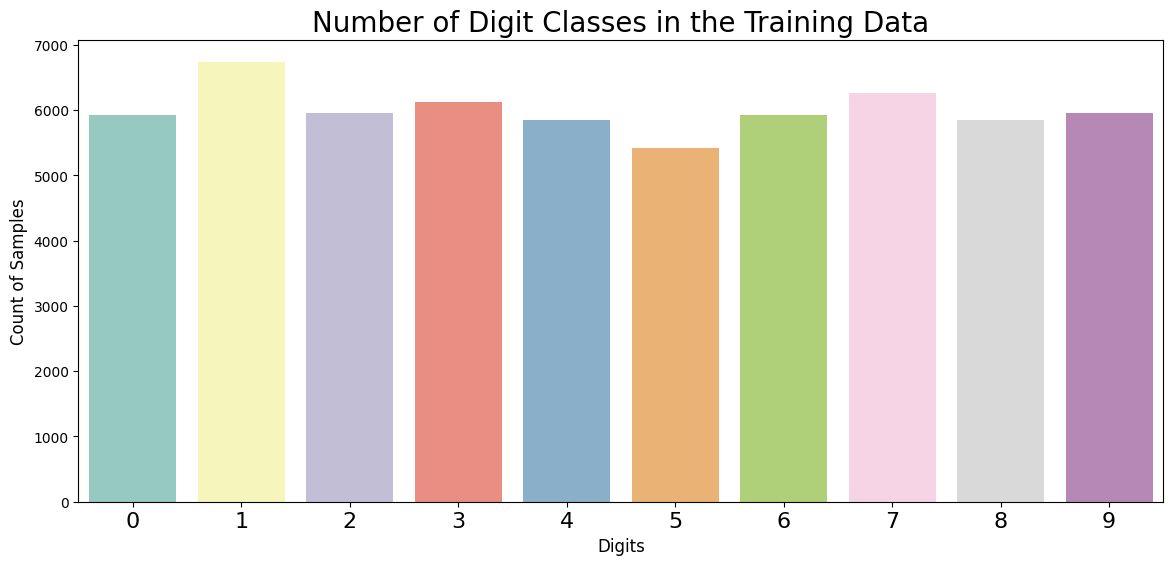

In [8]:
# Plot the number of samples for each digit class in the training data
plt.figure(figsize=(14, 6))
g = sns.countplot(x=train_df['label'], palette = 'Set3')
plt.title("Number of Digit Classes in the Training Data", size = 20)
plt.xticks(size = 16)
plt.xlabel("Digits", size = 12)
plt.ylabel("Count of Samples", size = 12)
train_df['label'].value_counts()

1    1135
2    1032
7    1028
3    1010
9    1009
4     982
0     980
8     974
6     958
5     892
Name: label, dtype: int64

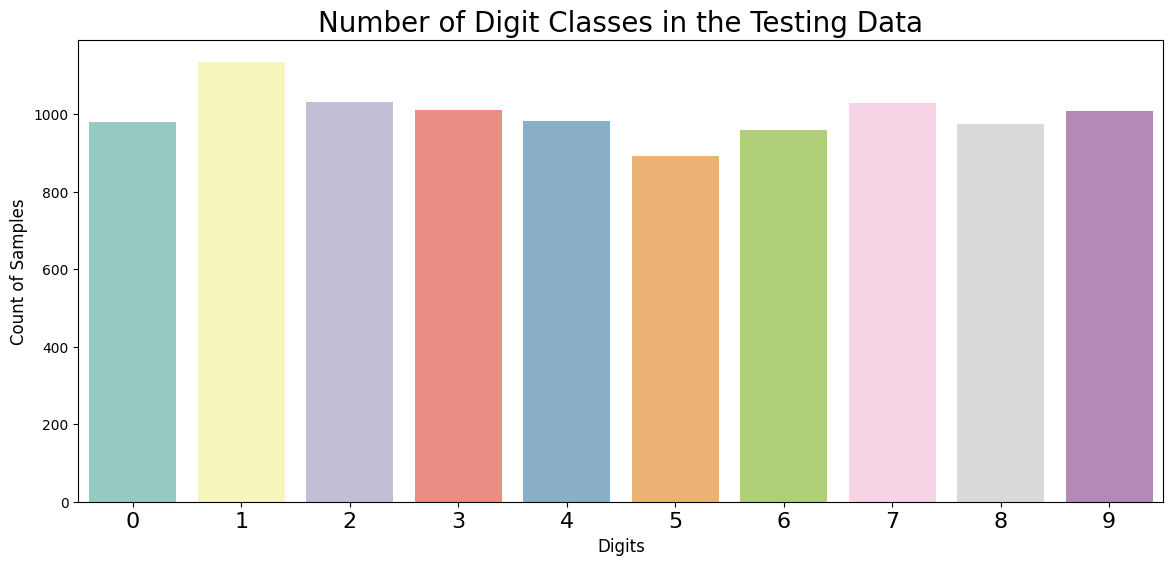

In [9]:
# Plot the number of samples for each digit class in the testing data
plt.figure(figsize=(14, 6))
g = sns.countplot(x=test_df['label'], palette = 'Set3')
plt.title("Number of Digit Classes in the Testing Data", size = 20)
plt.xticks(size = 16)
plt.xlabel("Digits", size = 12)
plt.ylabel("Count of Samples", size = 12)
test_df['label'].value_counts()

A random sample of 20 images from the training data


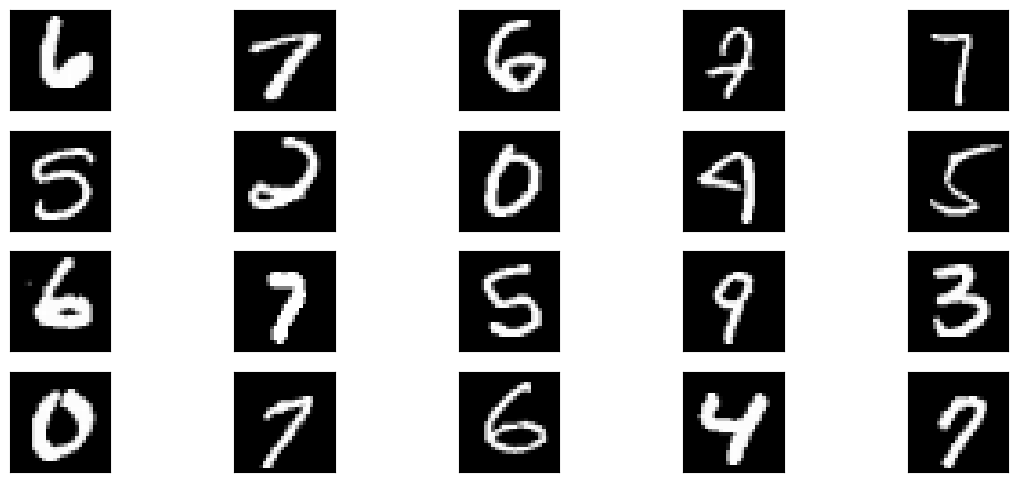

In [10]:
# Plot random some samples from the training data
rows, cols = 4, 5
print(f"A random sample of {rows*cols} images from the training data")
fig, ax = plt.subplots(rows, cols, figsize=(14, 6))
for i in range(rows):
    for j in range(cols):
        ax[i, j].imshow(X_train[random.randint(0, len(X_test))], cmap='gray')
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
plt.show()

A random sample of 20 images from the testing data


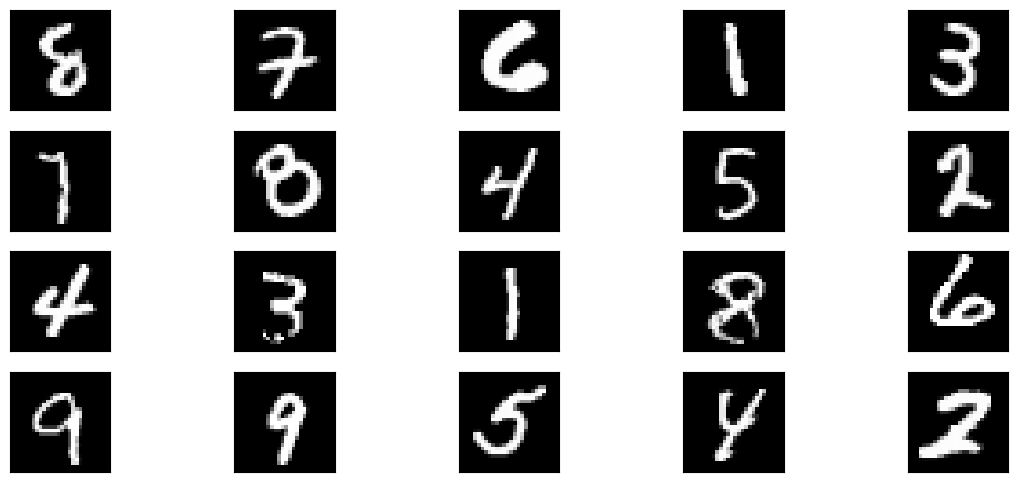

In [11]:
# Plot random some samples from the testing data
rows, cols = 4, 5
print(f"A random sample of {rows*cols} images from the testing data")
fig, ax = plt.subplots(rows, cols, figsize=(14, 6))
for i in range(rows):
    for j in range(cols):
        ax[i, j].imshow(X_test[random.randint(0, len(X_test))], cmap='gray')
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
plt.show()

### Data pre-processing

In [12]:
# Normalize the data
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# Convert the labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

### Load the model

In [13]:
# Load the model
load = False
if load:
    model = tf.keras.models.load_model('../mnist_rnn_before_enhancement.h5')

### Build & Compile model

In [26]:
def build_model(shape):
    model = tf.keras.models.Sequential([
        tf.keras.layers.SimpleRNN(units=64, dropout=0.2, input_shape=(shape), return_sequences=True),
        tf.keras.layers.SimpleRNN(units=32),
        tf.keras.layers.Dense(units=10, activation='softmax'),
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = build_model(X_train[0].shape)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 28, 64)            5952      
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense_2 (Dense)             (None, 10)                330       
                                                                 
Total params: 9,386
Trainable params: 9,386
Non-trainable params: 0
_________________________________________________________________


### Model fit

In [27]:
epochs = 10
batch_size = 16

history = model.fit(X_train, y_train, epochs=epochs, validation_split=0.2, batch_size=batch_size)

loss, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)

print(f"Loss: {loss*100:.2f}%")
print(f"Accuracy: {accuracy*100:.2f}%\n")

Epoch 1/10
3000/3000 [==============================] - 21s 7ms/step - loss: 0.5862 - accuracy: 0.8160 - val_loss: 0.3410 - val_accuracy: 0.9007
Epoch 2/10
3000/3000 [==============================] - 20s 7ms/step - loss: 0.3179 - accuracy: 0.9065 - val_loss: 0.2386 - val_accuracy: 0.9319
Epoch 3/10
3000/3000 [==============================] - 20s 7ms/step - loss: 0.2813 - accuracy: 0.9188 - val_loss: 0.1806 - val_accuracy: 0.9486
Epoch 4/10
3000/3000 [==============================] - 20s 7ms/step - loss: 0.2625 - accuracy: 0.9236 - val_loss: 0.1863 - val_accuracy: 0.9480
Epoch 5/10
3000/3000 [==============================] - 20s 7ms/step - loss: 0.2444 - accuracy: 0.9299 - val_loss: 0.2111 - val_accuracy: 0.9417
Epoch 6/10
3000/3000 [==============================] - 20s 7ms/step - loss: 0.2396 - accuracy: 0.9319 - val_loss: 0.2091 - val_accuracy: 0.9462
Epoch 7/10
3000/3000 [==============================] - 20s 7ms/step - loss: 0.2410 - accuracy: 0.9307 - val_loss: 0.1819 - val_ac

### Plots and tests

In [28]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

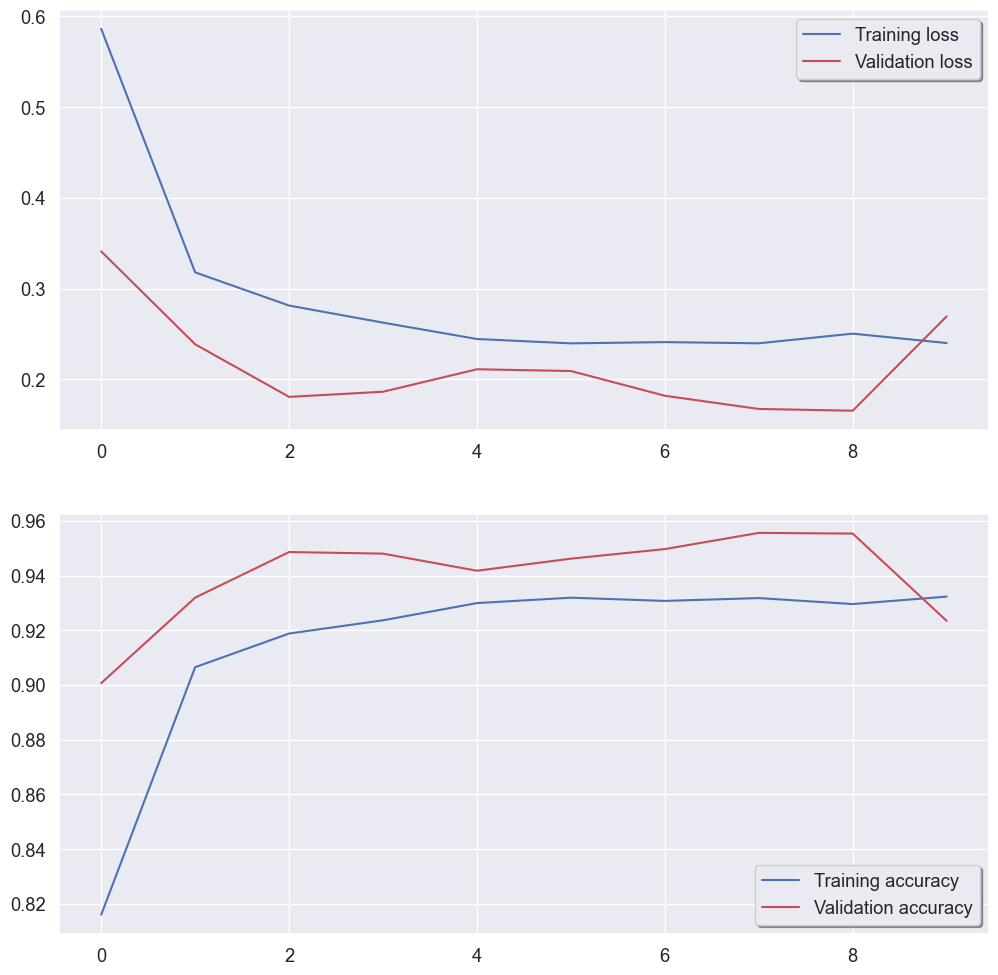

In [29]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2, 1, figsize=(12, 12))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss", axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

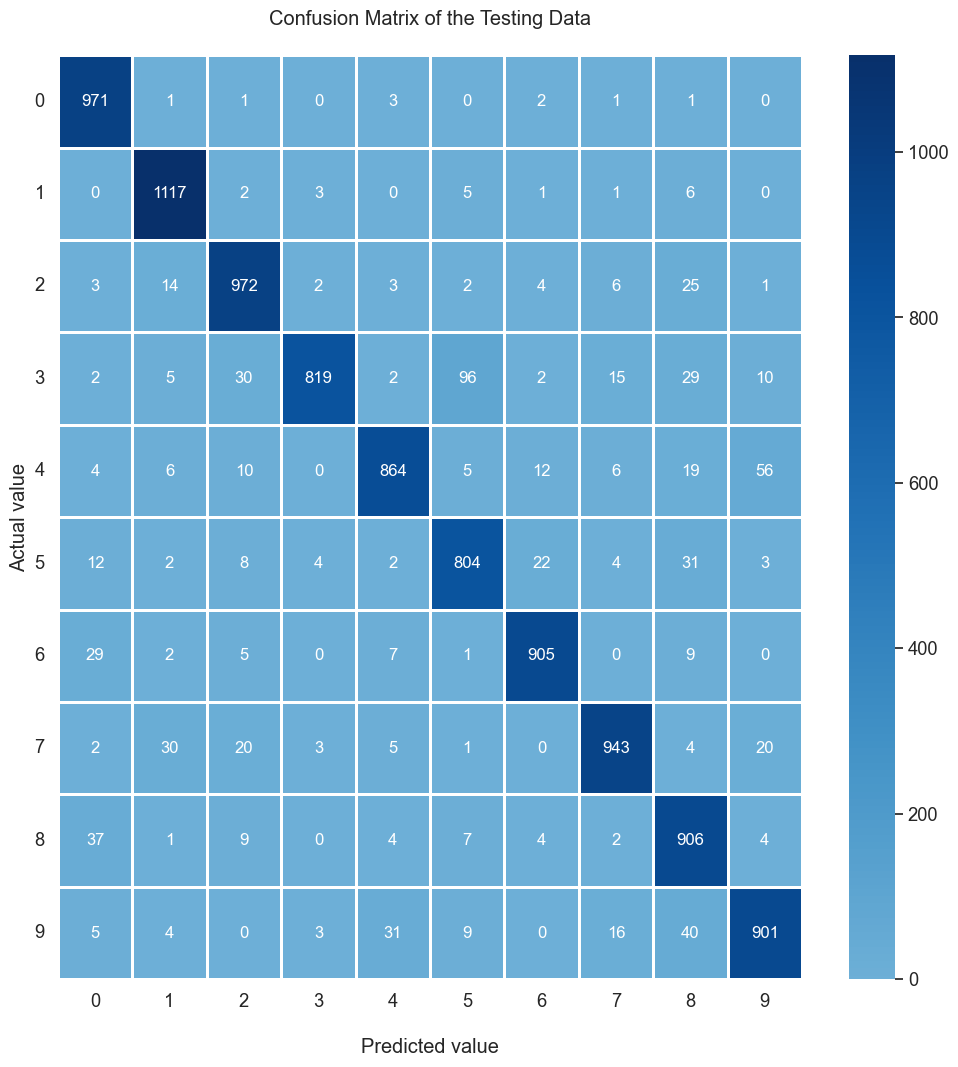

In [30]:
# Plot the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
f, ax = plt.subplots(figsize=(12, 12))
sns.set(font_scale=1.2)
sns.heatmap(confusion_mtx, annot=True, linewidths=1, annot_kws={"size": 12}, center=10.0, cmap="Blues", ax=ax, fmt='g')
ax.set(title="Confusion Matrix of the Testing Data\n",
      xlabel="\nPredicted value",
      ylabel="Actual value")
ax.set_xticklabels(labels=range(10), rotation=0, horizontalalignment='center', verticalalignment='top')
ax.set_yticklabels(labels=range(10), rotation=0, horizontalalignment='right', verticalalignment='center')
plt.show()

In [31]:
# Plot the classification report
target_names = [f"Class {i}" for i in range(10)]
print(classification_report(y_true, y_pred_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.91      0.99      0.95       980
     Class 1       0.95      0.98      0.96      1135
     Class 2       0.92      0.94      0.93      1032
     Class 3       0.98      0.81      0.89      1010
     Class 4       0.94      0.88      0.91       982
     Class 5       0.86      0.90      0.88       892
     Class 6       0.95      0.94      0.95       958
     Class 7       0.95      0.92      0.93      1028
     Class 8       0.85      0.93      0.89       974
     Class 9       0.91      0.89      0.90      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [32]:
# Print the multilabel confusion matrix
confusion_matrices = multilabel_confusion_matrix(y_true, y_pred_classes)

for i, matrix in zip(range(10), confusion_matrices):
    print(f"Class {i}:")
    print(f"True Positive(TP): {matrix[1][1]} - False Positive(FP): {matrix[0][1]}")
    print(f"False Negative(FN): {matrix[1][0]} - True Negative(TN): {matrix[0][0]}")
    print("----------------------------------------------------")

Class 0:
True Positive(TP): 971 - False Positive(FP): 94
False Negative(FN): 9 - True Negative(TN): 8926
----------------------------------------------------
Class 1:
True Positive(TP): 1117 - False Positive(FP): 65
False Negative(FN): 18 - True Negative(TN): 8800
----------------------------------------------------
Class 2:
True Positive(TP): 972 - False Positive(FP): 85
False Negative(FN): 60 - True Negative(TN): 8883
----------------------------------------------------
Class 3:
True Positive(TP): 819 - False Positive(FP): 15
False Negative(FN): 191 - True Negative(TN): 8975
----------------------------------------------------
Class 4:
True Positive(TP): 864 - False Positive(FP): 57
False Negative(FN): 118 - True Negative(TN): 8961
----------------------------------------------------
Class 5:
True Positive(TP): 804 - False Positive(FP): 126
False Negative(FN): 88 - True Negative(TN): 8982
----------------------------------------------------
Class 6:
True Positive(TP): 905 - False Pos

### Test the model

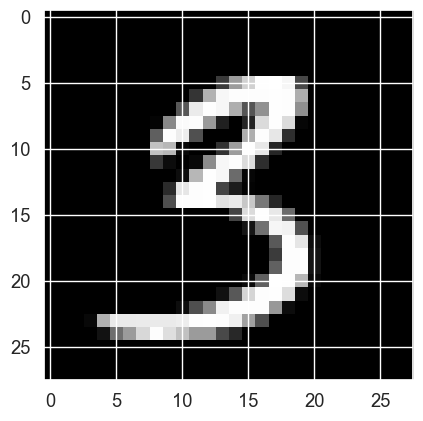

The image above is: 3
The model predicted: 5


In [35]:
# Test the model with a random image from the test dataset
i = random.randint(0, X_test.shape[0])
plt.imshow(X_test[i], cmap='gray')
plt.show()
print(f"The image above is: {np.argmax(y_test[i])}")

# Predict the class of the image
pred = model.predict(X_test[i].reshape(1, 28, 28))
print(f"The model predicted: {pred.argmax()}")

### Save the model

In [22]:
# Save the model
save = True
if save:
    model.save('../mnist_rnn_before_enhancement.h5')